In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy

In [36]:
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(0.2, 0.2)
])
training_data = datasets.Flowers102(root="data", split="train", download=True, transform=img_transform)
test_data = datasets.Flowers102(root="data", split="test", download=True, transform=img_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.6667,  0.0980, -0.9216],
         [-0.7059,  0.1176, -0.9608],
         [-0.7255,  0.1373, -0.9412],
         ...,
         [ 0.4706,  0.5490,  0.3922],
         [ 0.6667,  0.7843,  0.6667],
         [ 0.6863,  0.8824,  0.7647]],

        [[-0.7059, -0.0588, -0.9412],
         [-0.6471,  0.0588, -0.8824],
         [-0.5686,  0.1961, -0.7843],
         ...,
         [ 0.5686,  0.6078,  0.3922],
         [ 0.4902,  0.5686,  0.3725],
         [ 0.5098,  0.7059,  0.5098]],

        [[-0.6667, -0.2157, -0.8431],
         [-0.7059, -0.1961, -0.9216],
         [-0.6471, -0.0392, -0.8235],
         ...,
         [ 0.6275,  0.6667,  0.3137],
         [ 0.1373,  0.2157, -0.0980],
         [ 0.2353,  0.4510,  0.1765]],

        ...,

        [[-0.8235, -0.8627, -0.8824],
         [-0.9216, -0.9216, -0.9412],
         [-0.5490, -0.5098, -0.5098],
         ...,
         [-0.8627, -0.8235, -0.9020],
         [-0.8235, -0.7843, -0.8627],
         [-0.2549, -0.2157, -0.3137]],

        [[

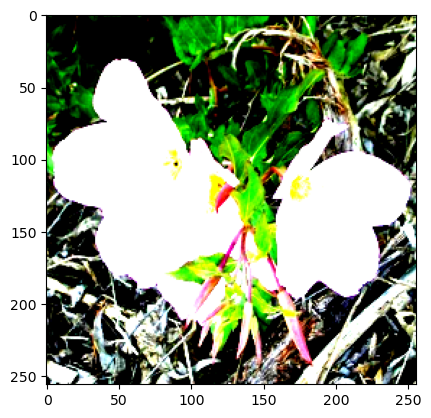

In [37]:
image = test_data[2][0]
plt.imshow(image.permute(1, 2, 0))
image.permute(1, 2, 0)

In [22]:
len(training_data), len(test_data)

(1020, 6149)

In [38]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

class FlowersModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(32 * 64 * 64, 102)
        self.softmax = nn.Softmax(dim=1)
        self.output = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool,
            self.conv2,
            self.relu,
            self.pool,
            self.flatten,
            # self.dropout,
            self.linear,
            self.softmax
        )

    def forward(self, x):
        return self.output(x)

model = FlowersModel().to(device)
model

FlowersModel(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=131072, out_features=102, bias=True)
  (softmax): Softmax(dim=1)
  (output): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=131072, out_features=102, bias=True)
    (8): Softmax(dim=1)
  )
)

In [40]:
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), learning_rate)

In [43]:
def train(dataloader: DataLoader, training_model: nn.Module, optim: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    training_model.train()
    for batch_no, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred = training_model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        if batch_no % 10 == 0:
            loss, current = loss.item(), (batch_no + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader:DataLoader, eval_model: nn.Module, losses: list, accuracy: list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = eval_model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size

    losses.append(total_loss)
    accuracy.append(100 * correct)

    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")


In [46]:
epochs = 20
losses = []
accuracy = []

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, optimiser)
    test(test_dataloader, model, losses, accuracy)
print("Done!")


Epoch 1
-------------------------------
loss: 4.418181 [   32/ 1020]
loss: 4.390095 [  352/ 1020]
loss: 4.452420 [  672/ 1020]
loss: 4.585145 [  992/ 1020]
Test Error: 
 Accuracy: 6.7%, Avg loss: 4.577505 

Epoch 2
-------------------------------
loss: 4.513556 [   32/ 1020]
loss: 4.375472 [  352/ 1020]
loss: 4.509784 [  672/ 1020]
loss: 4.390115 [  992/ 1020]
Test Error: 
 Accuracy: 6.6%, Avg loss: 4.579094 

Epoch 3
-------------------------------
loss: 4.319220 [   32/ 1020]
loss: 4.464095 [  352/ 1020]
loss: 4.390027 [  672/ 1020]
loss: 4.459558 [  992/ 1020]
Test Error: 
 Accuracy: 6.7%, Avg loss: 4.578547 

Epoch 4
-------------------------------
loss: 4.481559 [   32/ 1020]
loss: 4.420701 [  352/ 1020]
loss: 4.422218 [  672/ 1020]
loss: 4.451771 [  992/ 1020]
Test Error: 
 Accuracy: 6.3%, Avg loss: 4.581917 

Epoch 5
-------------------------------
loss: 4.420011 [   32/ 1020]
loss: 4.358211 [  352/ 1020]
loss: 4.391852 [  672/ 1020]
loss: 4.418198 [  992/ 1020]
Test Error: 
 Ac

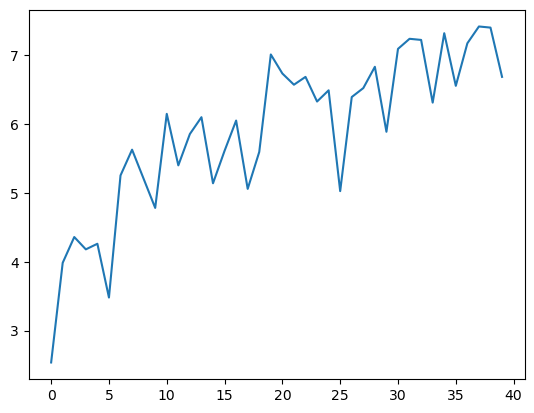

In [47]:
plt.plot(accuracy)

In [49]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth
